# Doublet identification in Multiome-RNA (adult) dataset using _scrublet_ 

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import matplotlib.pyplot as plt

import tables
import scipy.sparse as sp
from typing import Dict
# from fastprogress.fastprogress import  progress_bar

from scanpy import logging as logg
from scanpy.neighbors import neighbors
from anndata import AnnData
from scipy.sparse import csc_matrix

In [2]:
sc.settings.verbosity = 3
sc.logging.print_version_and_date()
sc.settings.set_figure_params(dpi = 160, color_map = 'RdPu', dpi_save = 180, vector_friendly = True, format = 'svg')

Running Scanpy 1.4.4.post1, on 2021-09-21 15:20.


In [3]:
# From Kazumasa
def dict_from_h5(file: str) -> Dict[str, np.ndarray]:
    """Read in everything from an h5 file and put into a dictionary."""
    d = {}
    with tables.open_file(file) as f:
        # read in everything
        for array in f.walk_nodes("/", "Array"):
            d[array.name] = array.read()
    return d


def anndata_from_h5(file: str,
                    analyzed_barcodes_only: bool = True) -> 'anndata.AnnData':
    """Load an output h5 file into an AnnData object for downstream work.

    Args:
        file: The h5 file
        analyzed_barcodes_only: False to load all barcodes, so that the size of
            the AnnData object will match the size of the input raw count matrix.
            True to load a limited set of barcodes: only those analyzed by the
            algorithm. This allows relevant latent variables to be loaded
            properly into adata.obs and adata.obsm, rather than adata.uns.

    Returns:
        adata: The anndata object, populated with inferred latent variables
            and metadata.

    """

    try:
        import anndata
    except ImportError:
        raise ImportError('The anndata package must be installed to use the '
                          'function anndata_from_h5()')

    d = dict_from_h5(file)
    X = sp.csc_matrix((d.pop('data'), d.pop('indices'), d.pop('indptr')),
                      shape=d.pop('shape')).transpose().tocsr()

    if analyzed_barcodes_only:
        if 'barcodes_analyzed_inds' in d.keys():
            X = X[d['barcodes_analyzed_inds'], :]
            d['barcodes'] = d['barcodes'][d['barcodes_analyzed_inds']]
        elif 'barcode_indices_for_latents' in d.keys():
            X = X[d['barcode_indices_for_latents'], :]
            d['barcodes'] = d['barcodes'][d['barcode_indices_for_latents']]
        else:
            print('Warning: analyzed_barcodes_only=True, but the key '
                  '"barcodes_analyzed_inds" or "barcode_indices_for_latents" '
                  'is missing from the h5 file. '
                  'Will output all barcodes, and proceed as if '
                  'analyzed_barcodes_only=False')

    # Construct the count matrix.
    adata = anndata.AnnData(X=X,
                            obs={'barcode': d.pop('barcodes').astype(str)},
                            var={'gene_name': (d.pop('gene_names') if 'gene_names' in d.keys()
                                               else d.pop('name')).astype(str)})
    adata.obs.set_index('barcode', inplace=True)
    adata.var.set_index('gene_name', inplace=True)

    # Add other information to the adata object in the appropriate slot.
    for key, value in d.items():
        try:
            value = np.asarray(value)
            if len(value.shape) == 0:
                adata.uns[key] = value
            elif value.shape[0] == X.shape[0]:
                if (len(value.shape) < 2) or (value.shape[1] < 2):
                    adata.obs[key] = value
                else:
                    adata.obsm[key] = value
            elif value.shape[0] == X.shape[1]:
                if value.dtype.name.startswith('bytes'):
                    adata.var[key] = value.astype(str)
                else:
                    adata.var[key] = value
            else:
                adata.uns[key] = value
        except Exception:
            print('Unable to load data into AnnData: ', key, value, type(value))

    if analyzed_barcodes_only:
        for col in adata.obs.columns[adata.obs.columns.str.startswith('barcodes_analyzed')
                                     | adata.obs.columns.str.startswith('barcode_indices')]:
            try:
                del adata.obs[col]
            except Exception:
                pass

    return adata

## Create AnnData objects

In [4]:
path = '/nfs/team205/kk18/data/soupremoved/cellbender020/'
all_sample_ids = ['HCAHeart9508627', 'HCAHeart9508628', 'HCAHeart9508629', 
                  'HCAHeart9845431', 'HCAHeart9845432', 'HCAHeart9845433', 
                  'HCAHeart9845434', 'HCAHeart9845435', 'HCAHeart9845436']

adatas = [anndata_from_h5(path + sample_id + '/' + sample_id + '_cellbender_out_filtered.h5', analyzed_barcodes_only=False) for sample_id in all_sample_ids]

In [5]:
n_nuclei=[adatas[i].n_obs for i in range(len(adatas))]

In [6]:
pd.DataFrame({'samples' : all_sample_ids, 'n_nuclei' : n_nuclei})

,samples,n_nuclei
0,HCAHeart9508627,3686
1,HCAHeart9508628,12696
2,HCAHeart9508629,10459
3,HCAHeart9845431,9167
4,HCAHeart9845432,4654
5,HCAHeart9845433,5033
6,HCAHeart9845434,9522
7,HCAHeart9845435,7698
8,HCAHeart9845436,8640


In [7]:
metadata = pd.read_csv('/lustre/scratch117/cellgen/team205/dm19/kazu/data/metadata/metadata_adult_multiomeRNA.csv', sep = ',', index_col = 0)

In [8]:
metadata

,Foetal_or_Adult,Provider,Modality,Chemistry,Mapping_ver,Reference_genome
sample_id,,,,,,
HCAHeart9508627,Adult,Sanger Heart Mona-Carlos,Multiome-RNA,Single Cell Multiome ATAC + Gene Expression v1,cellranger-arc-1.0.1,GRCh38-2020-A
HCAHeart9508628,Adult,Sanger Heart Mona-Carlos,Multiome-RNA,Single Cell Multiome ATAC + Gene Expression v1,cellranger-arc-1.0.1,GRCh38-2020-A
HCAHeart9508629,Adult,Sanger Heart Mona-Carlos,Multiome-RNA,Single Cell Multiome ATAC + Gene Expression v1,cellranger-arc-1.0.1,GRCh38-2020-A
HCAHeart9845431,Adult,Sanger Heart Mona-Carlos,Multiome-RNA,Single Cell Multiome ATAC + Gene Expression v1,cellranger-arc-1.0.1,GRCh38-2020-A
HCAHeart9845432,Adult,Sanger Heart Mona-Carlos,Multiome-RNA,Single Cell Multiome ATAC + Gene Expression v1,cellranger-arc-1.0.1,GRCh38-2020-A
HCAHeart9845433,Adult,Sanger Heart Mona-Carlos,Multiome-RNA,Single Cell Multiome ATAC + Gene Expression v1,cellranger-arc-1.0.1,GRCh38-2020-A
HCAHeart9845434,Adult,Sanger Heart Mona-Carlos,Multiome-RNA,Single Cell Multiome ATAC + Gene Expression v1,cellranger-arc-1.0.1,GRCh38-2020-A
HCAHeart9845435,Adult,Sanger Heart Mona-Carlos,Multiome-RNA,Single Cell Multiome ATAC + Gene Expression v1,cellranger-arc-1.0.1,GRCh38-2020-A
HCAHeart9845436,Adult,Sanger Heart Mona-Carlos,Multiome-RNA,Single Cell Multiome ATAC + Gene Expression v1,cellranger-arc-1.0.1,GRCh38-2020-A


In [9]:
for i in range(len(adatas)):
    adatas[i].var_names_make_unique()
    adatas[i].obs['sample_id'] = metadata.index[i]
    adatas[i].obs.index = metadata.index[i] + '_' + adatas[i].obs.index 
    for col in metadata.columns:
        adatas[i].obs[col] = metadata[col][i]

adata = adatas[0].concatenate(adatas[1:], batch_categories = metadata.index)
adata.shape

(71555, 36601)

In [10]:
adata.write('/home/jovyan/heart/outputs/01_MultiomeRNA_scrublet/multiomeRNA_adult_heart.h5ad')

... storing 'sample_id' as categorical
... storing 'Foetal_or_Adult' as categorical
... storing 'Provider' as categorical
... storing 'Modality' as categorical
... storing 'Chemistry' as categorical
... storing 'Mapping_ver' as categorical
... storing 'Reference_genome' as categorical
... storing 'feature_type' as categorical


In [11]:
adata.obs['n_counts'] = adata.X.sum(axis = 1)
adata.obs['n_counts'].describe()

count     71555.000000
mean       9878.979492
std       16522.539062
min           0.000000
25%        1811.000000
50%        4827.000000
75%       12263.000000
max      463580.000000
Name: n_counts, dtype: float64

## Remove cells with less than 200 genes, remove genes detected in less than 3 cells

In [12]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 802 cells that have less than 200 genes expressed


/home/jovyan/my-conda-envs/heart/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


filtered out 2993 genes that are detected in less than 3 cells


In [13]:
adata.shape

(70753, 33608)

## Compute QC stats

In [14]:
mito_cells = adata.var_names.str.startswith('MT-')
ribo_cells = adata.var_names.str.startswith('RPS','RPL')
adata.obs['percent_mito'] = np.sum(adata[:, mito_cells].X, axis = 1) / np.sum(adata.X, axis = 1)
adata.obs['percent_ribo'] = np.sum(adata[:, ribo_cells].X, axis = 1) / np.sum(adata.X, axis = 1)

# sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito', 'percent_ribo'], jitter = 0.2, multi_panel = True)
# for qc_metric in ['n_genes', 'n_counts', 'percent_mito', 'percent_ribo']:
#     sc.pl.violin(adata, qc_metric, jitter = 0.2)

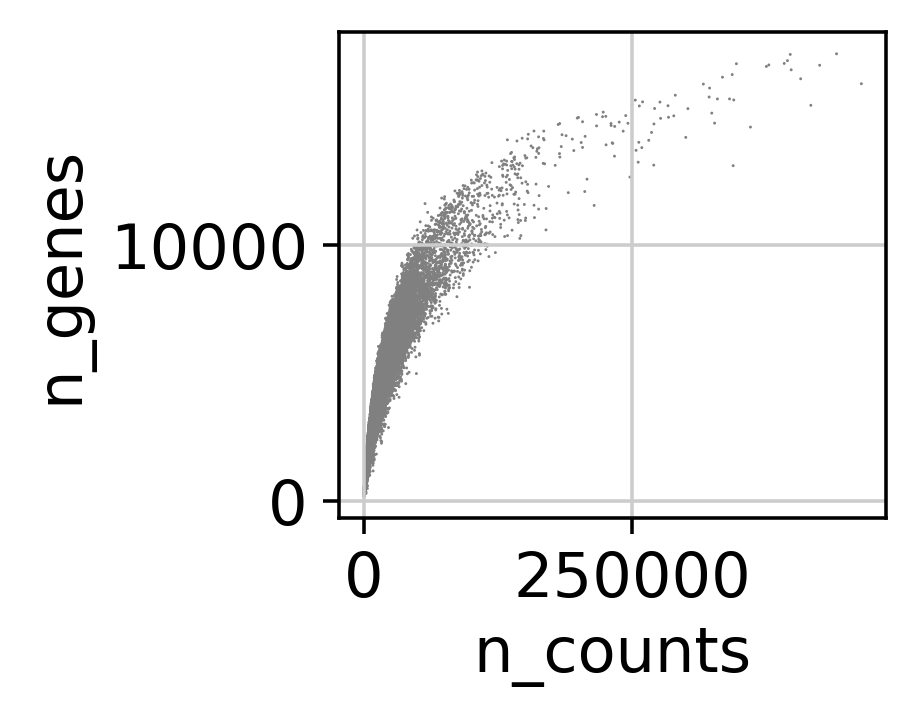

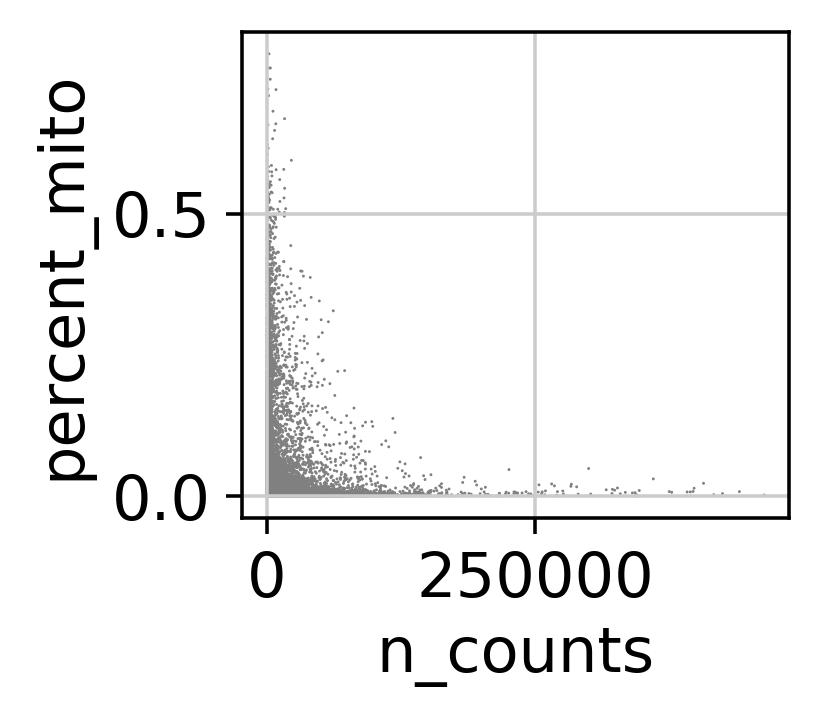

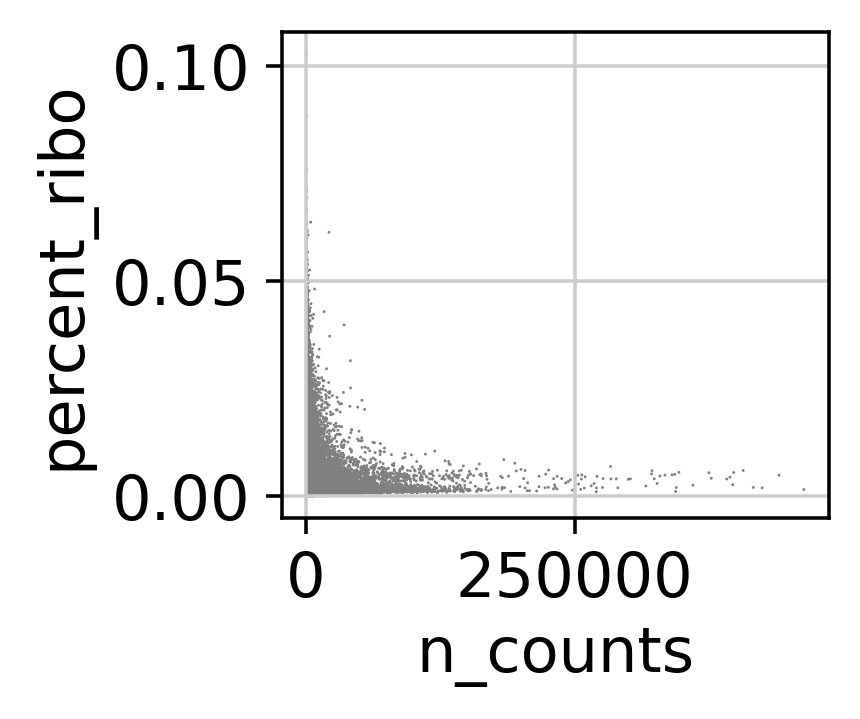

In [15]:
plt.rcParams['figure.figsize'] = [3, 2]

sc.pl.scatter(adata, x='n_counts', y='n_genes')
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='percent_ribo')

## Remove cells exceeding the ribo/mito threshold

/home/jovyan/my-conda-envs/heart/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jovyan/my-conda-envs/heart/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jovyan/my-conda-envs/heart/lib/python3.8/site-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/home/jovyan/my-conda-envs/heart/lib/python3.8/site-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/home/jovyan/my-conda-envs/hea

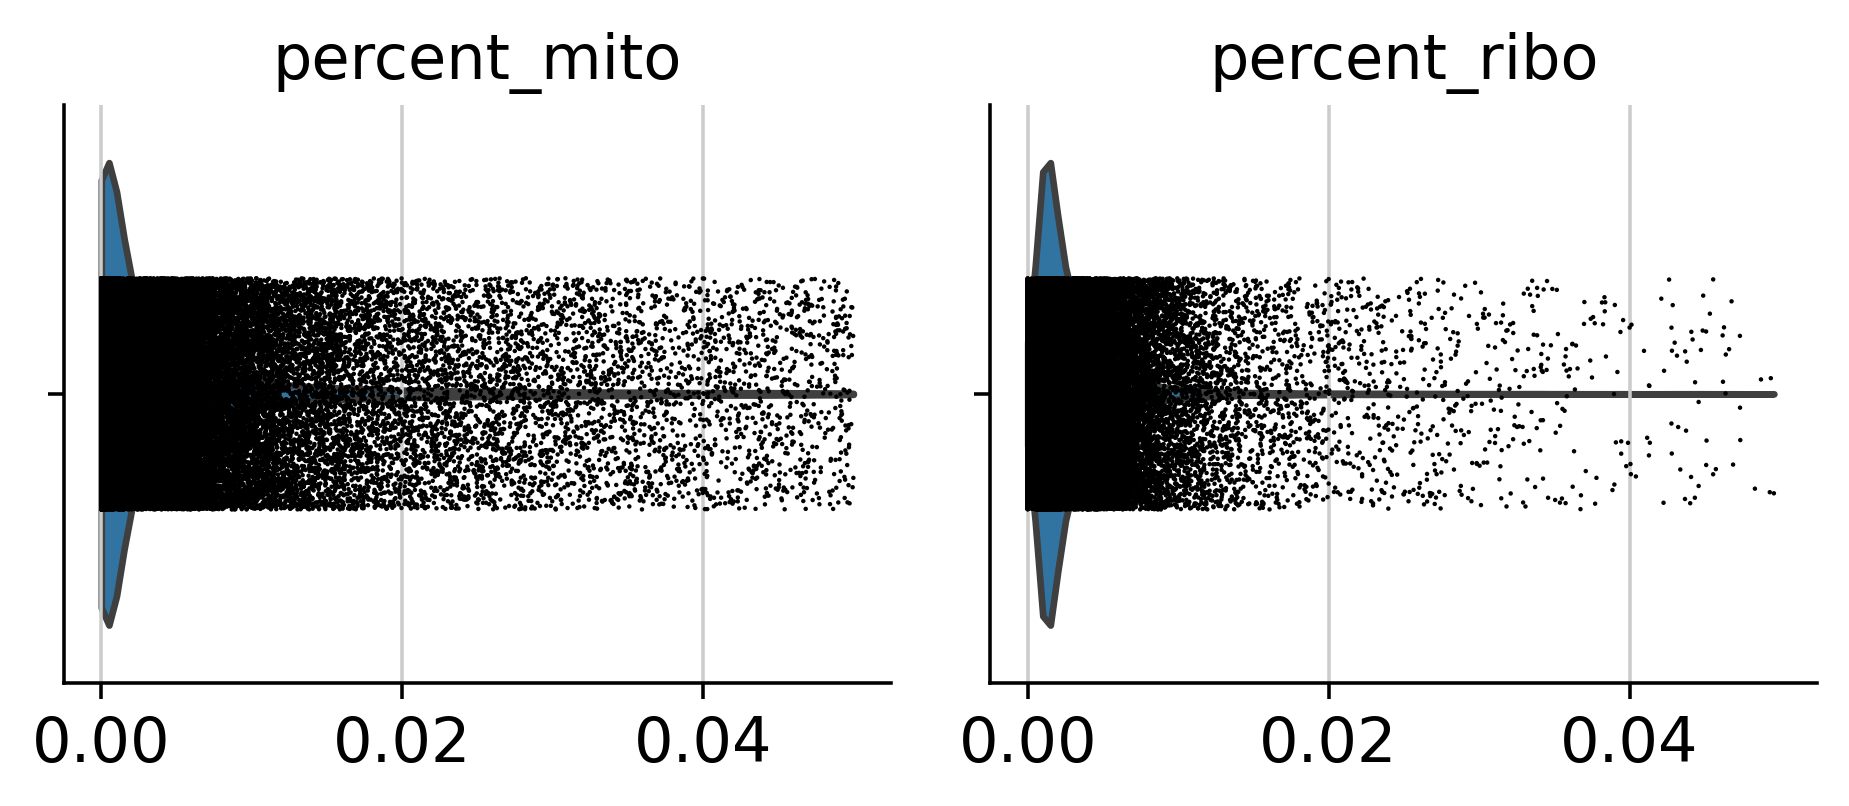

In [16]:
plt.rcParams['figure.figsize'] = [2, 2]
adata = adata[adata.obs['percent_mito'] < 0.05, :]
adata = adata[adata.obs['percent_ribo'] < 0.05, :]
sc.pl.violin(adata, ['percent_mito', 'percent_ribo'],jitter = 0.2, multi_panel = True)

In [17]:
adata.shape

(66504, 33608)

Expected doublet rate in scrublet based on the cellbender output nuclei number and the [protocol](https://assets.ctfassets.net/an68im79xiti/7x5E4P6xefQruTbFg0yr3a/1381fdcd2d2e7d667ef5b415119dab15/CG000338_ChromiumNextGEM_Multiome_ATAC_GEX_User_Guide_RevE.pdf)

In [18]:
expected_doublet_rate = [0.031, 0.077, 0.077, 0.069, 0.039, 0.039, 0.077, 0.062, 0.069]

In [19]:
np.mean(expected_doublet_rate)

0.060000000000000005

In [20]:
scrub = scr.Scrublet(adata.X, expected_doublet_rate = np.mean(expected_doublet_rate))

In [21]:
adata.obs['doublet_scores'], adata.obs['predicted_doublets'] = scrub.scrub_doublets(min_counts=2, min_cells=3, 
                                                                                    min_gene_variability_pctl=85, n_prin_comps=30)

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...


Trying to set attribute `.obs` of view, copying.


Automatically set threshold at doublet score = 0.64
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 5.1%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 0.5%
Elapsed time: 235.5 seconds


(<Figure size 1280x480 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Observed transcriptomes'}, xlabel='Doublet score', ylabel='Prob. density'>,
        <AxesSubplot:title={'center':'Simulated doublets'}, xlabel='Doublet score', ylabel='Prob. density'>],
       dtype=object))

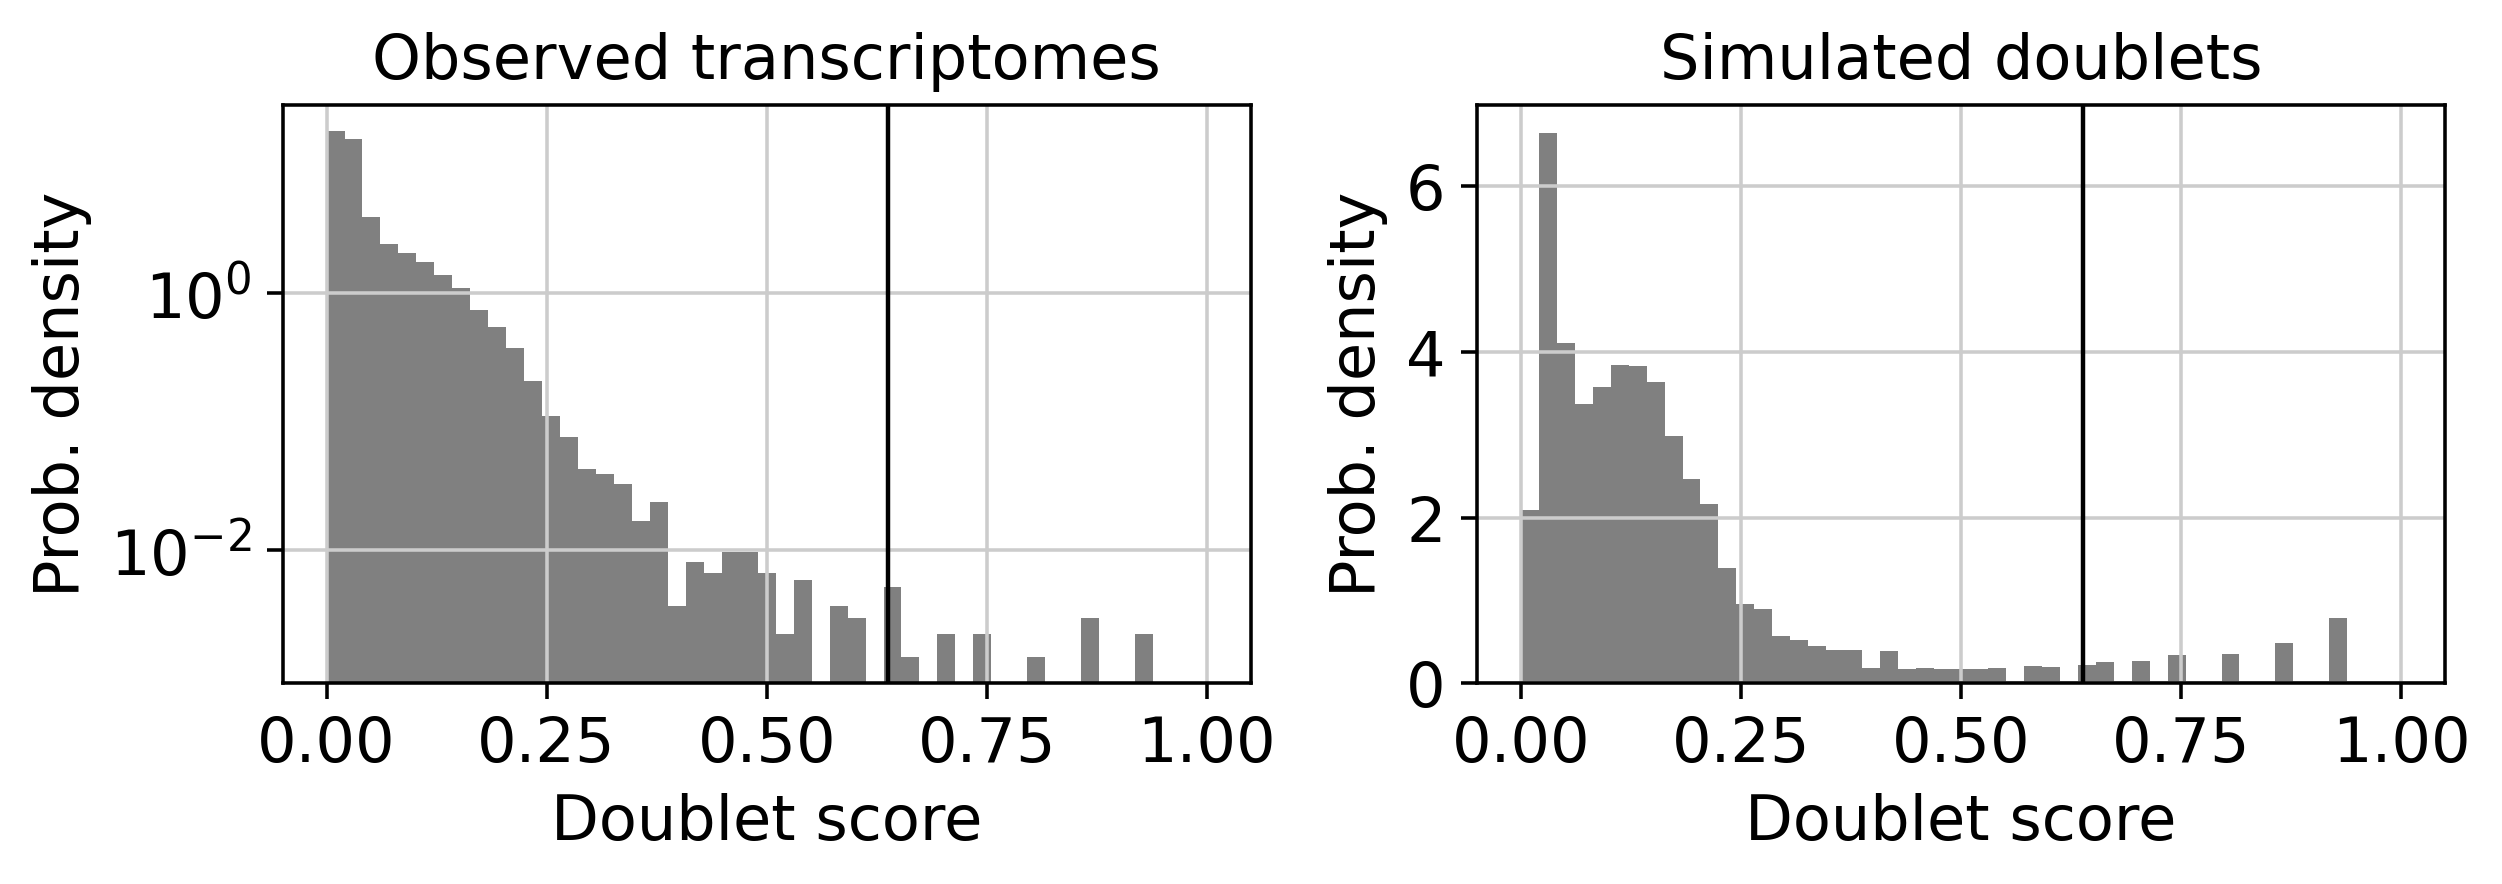

In [22]:
scrub.plot_histogram()

In [23]:
scrub.call_doublets(threshold=0.25)

Detected doublet rate = 0.8%
Estimated detectable doublet fraction = 17.5%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 4.4%


array([False, False, False, ..., False, False, False])

(<Figure size 1280x480 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Observed transcriptomes'}, xlabel='Doublet score', ylabel='Prob. density'>,
        <AxesSubplot:title={'center':'Simulated doublets'}, xlabel='Doublet score', ylabel='Prob. density'>],
       dtype=object))

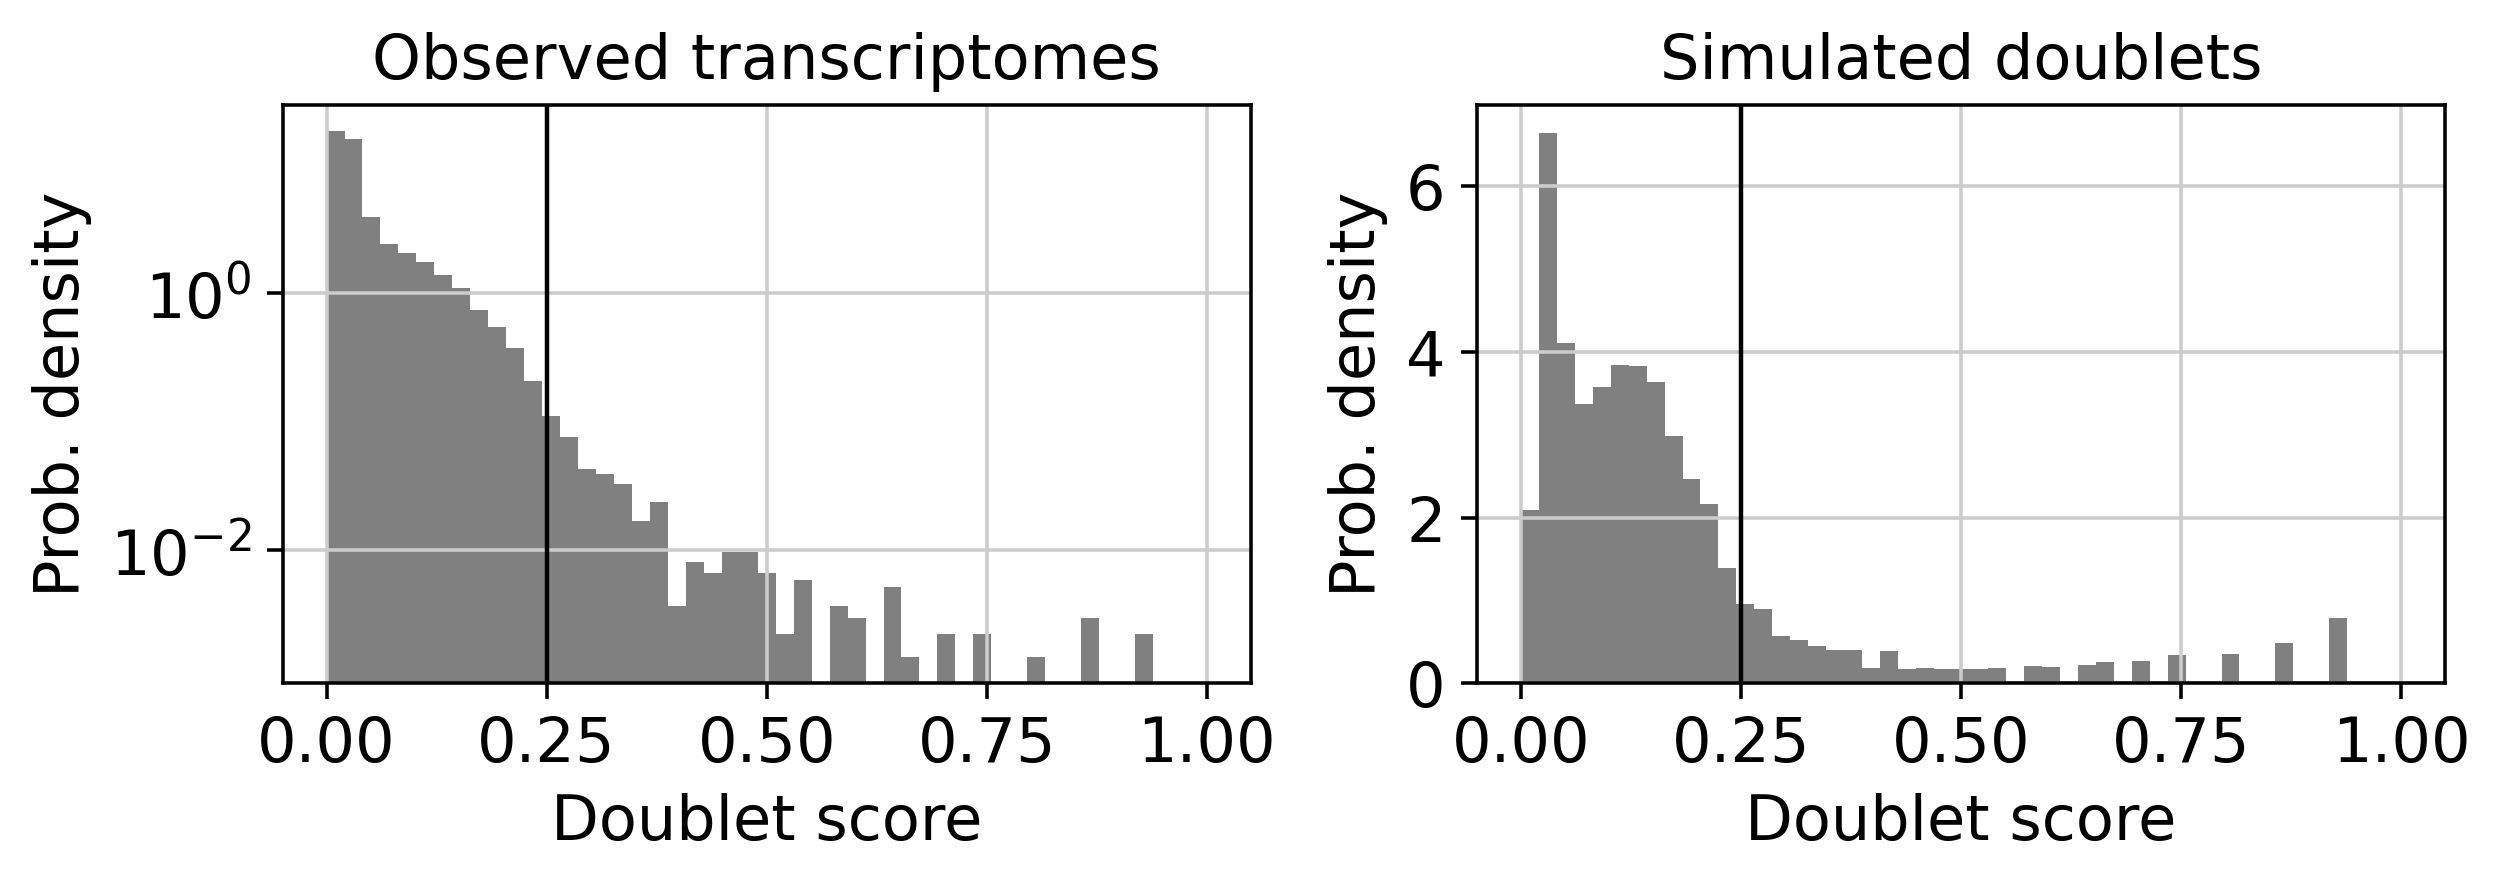

In [24]:
scrub.plot_histogram()

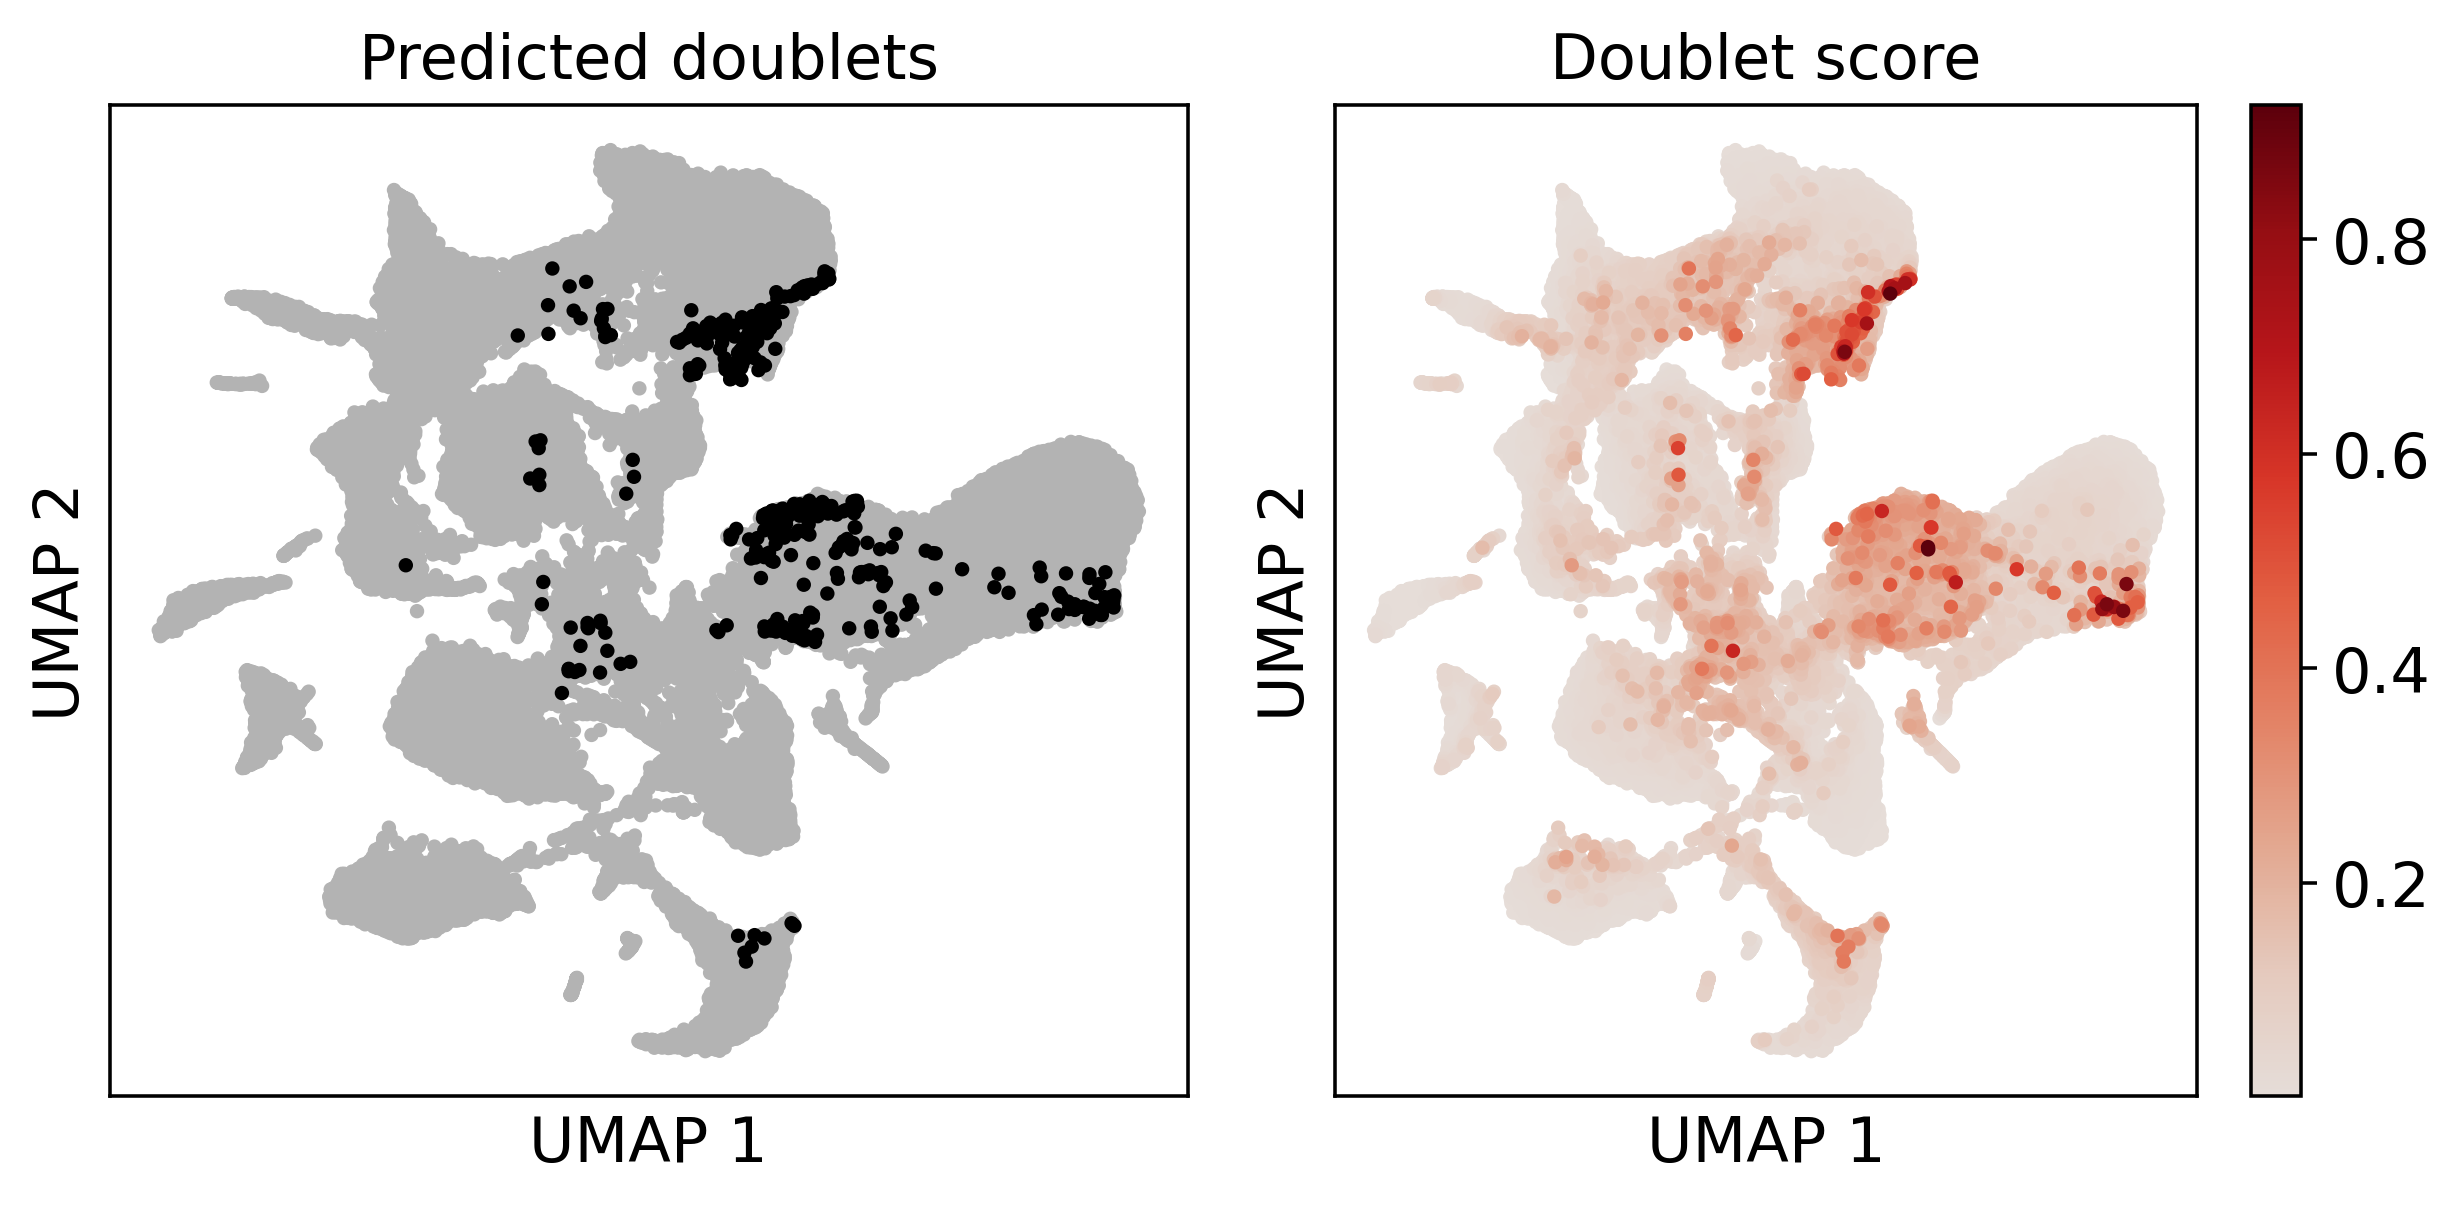

In [25]:
scrub.set_embedding('UMAP', scr.get_umap(scrub.manifold_obs_, 10, min_dist=0.3))
scrub.plot_embedding('UMAP', order_points=True);

In [26]:
adata.obs['predicted_doublets'].value_counts()

False    66487
True        17
Name: predicted_doublets, dtype: int64

In [27]:
pd.DataFrame(adata.obs).to_csv("scrublet_calls.tsv",sep = '\t',header = False)

In [28]:
adata.write('/nfs/team205/heart/anndata_objects/multiome_RNA_adult.h5ad')

## Test by varying expected doublet rate estimates a number of doublets much larger than expected

In [29]:
pd.DataFrame({'samples' : all_sample_ids, 'n_nuclei' : n_nuclei, 'expected_doublet_rate' : expected_doublet_rate})

,samples,n_nuclei,expected_doublet_rate
0,HCAHeart9508627,3686,0.031
1,HCAHeart9508628,12696,0.077
2,HCAHeart9508629,10459,0.077
3,HCAHeart9845431,9167,0.069
4,HCAHeart9845432,4654,0.039
5,HCAHeart9845433,5033,0.039
6,HCAHeart9845434,9522,0.077
7,HCAHeart9845435,7698,0.062
8,HCAHeart9845436,8640,0.069


In [30]:
scrubs = [scr.Scrublet(adata[adata.obs.sample_id == all_sample_ids[i],:].X, expected_doublet_rate = expected_doublet_rate[i]) for i in range(len(all_sample_ids))]

/home/jovyan/my-conda-envs/heart/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Calling the main function, `scrub_doublets`, calculates a score for each cell, and assigns the binary (doublet/singlet) prediction based on this score. We can store this data as metadata in the `adata` object.

In [31]:
adata.obs['doublet_scores'] = np.nan
adata.obs['predicted_doublets'] = np.nan

In [32]:
for i in range(len(all_sample_ids)):
    doublet_scores, predicted_doublets = scrubs[i].scrub_doublets(min_counts=2, min_cells=3, min_gene_variability_pctl=85, 
                                                                  n_prin_comps=30)
    adata.obs.loc[adata.obs.sample_id == all_sample_ids[i], 'doublet_scores'] = doublet_scores
    adata.obs.loc[adata.obs.sample_id == all_sample_ids[i], 'predicted_doublets'] = predicted_doublets

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.30
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 0.2%
Overall doublet rate:
	Expected   = 3.1%
	Estimated  = 23.5%
Elapsed time: 9.0 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.08
Detected doublet rate = 37.7%
Estimated detectable doublet fraction = 83.1%
Overall doublet rate:
	Expected   = 7.7%
	Estimated  = 45.4%
Elapsed time: 28.7 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.09
Detected doublet rate = 34.5%
Estimated detectable doublet fraction = 83.7%
Overall doublet rate:
	Expected   = 7.7%
	Estimated  = 41.3%
Elapsed time: 30.6 seconds
Preprocessing...
Simulating dou